In [ ]:
Load and preprocess the dataset: Parse the legend.csv to load images and their corresponding labels.
Prepare the data: Split the dataset into training and validation sets. Convert labels to a numerical format using LabelEncoder.
Preprocess the images: Resize the images to the size expected by VGG16 (224x224 pixels) and normalize the pixel values.
Load and modify the VGG16 model: Load the pre-trained VGG16 model, freeze its layers, and add custom fully connected layers for emotion classification.
Train the model: Use the data generators with image augmentation for training and validation.

In [1]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Load dataset function
def load_dataset(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for img in os.listdir(label_dir):
                images.append(os.path.join(label_dir, img))  # Full image path
                labels.append(label)  # Folder name is the label
            print(f"{label} Completed")
    return images, labels

# Load and shuffle training data
TRAIN_DIR = 'data_split/train'
train = pd.DataFrame()
train['image'], train['emotion'] = load_dataset(TRAIN_DIR)
train = train.sample(frac=1).reset_index(drop=True)

# Extract features from images
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale', target_size=(48, 48))  # 48x48 grayscale image
        img = np.array(img)
        features.append(img)
    
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Add channel dimension for grayscale
    return features

# Normalize image data
def preprocess_images():
    train_features = extract_features(train['image'])
    x_train = train_features / 255.0

    # Label encoding
    le = LabelEncoder()
    le.fit(train['emotion'])
    y_train = le.transform(train['emotion'])
    
    return x_train, y_train, le

x_train, y_train, le = preprocess_images()

# Load and preprocess test data (you can do similar steps as for training data)
TEST_DIR = 'data_split/test'
test = pd.DataFrame()
test['image'], test['emotion'] = load_dataset(TEST_DIR)
test_features = extract_features(test['image'])
x_test = test_features / 255.0
y_test = le.transform(test['emotion'])

# Final check for shapes
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


100%|███████████████████████████████████████████████████████████████████████████| 10947/10947 [00:18<00:00, 605.57it/s]


anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


100%|█████████████████████████████████████████████████████████████████████████████| 2738/2738 [00:04<00:00, 622.90it/s]


x_train shape: (10947, 48, 48, 1)
y_train shape: (10947,)
x_test shape: (2738, 48, 48, 1)
y_test shape: (2738,)


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the AlexNet-inspired model
def build_alexnet_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # First convolutional layer
    x = Conv2D(96, (11, 11), strides=4, padding="same", activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    
    # Second convolutional layer
    x = Conv2D(256, (5, 5), padding="same", activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2)(x)
    
    # Third convolutional layer
    x = Conv2D(384, (3, 3), padding="same", activation='relu')(x)
    
    # Fourth convolutional layer
    x = Conv2D(384, (3, 3), padding="same", activation='relu')(x)
    
    # Fifth convolutional layer
    x = Conv2D(256, (3, 3), padding="same", activation='relu')(x)
    
    # Modify MaxPooling to handle smaller dimensions (after the 5th convolution)
    x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)  # Changed to (2x2) pool size
    
    # Flatten the output from the convolutional layers
    x = Flatten()(x)
    
    # Fully connected layer (Dense layer)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Another fully connected layer
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    # Output layer with softmax activation for multi-class classification
    output = Dense(num_classes, activation='softmax')(x)
    
    # Define the model
    model = Model(inputs, output)
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the input shape (48x48 grayscale images with 1 channel) and number of classes
input_shape = (48, 48, 1)
num_classes = len(le.classes_)  # The number of unique emotions

# Create the AlexNet-inspired model
model = build_alexnet_model(input_shape, num_classes)

# Print the model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 96)          │          11,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 96)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 5, 5, 256)           │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 2, 2, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 2, 2, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 2, 2, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │          32,776 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,592,136 (82.37 MB)

 Trainable params: 21,591,432 (82.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 82s 228ms/step - accuracy: 0.4736 - loss: 1.2073 - val_accuracy: 0.4996 - val_loss: 1.0729
Epoch 2/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 76s 222ms/step - accuracy: 0.5080 - loss: 1.0500 - val_accuracy: 0.5464 - val_loss: 1.0949
Epoch 3/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.6884 - loss: 0.8884 - val_accuracy: 0.5274 - val_loss: 1.4800
Epoch 4/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 80s 233ms/step - accuracy: 0.7323 - loss: 0.8194 - val_accuracy: 0.4763 - val_loss: 1.4079
Epoch 5/5
343/343 ━━━━━━━━━━━━━━━━━━━━ 79s 231ms/step - accuracy: 0.7728 - loss: 0.7210 - val_accuracy: 0.6687 - val_loss: 0.8970


In [7]:
model.save('emotion_recognition_alexnet_model.keras')


Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Output: neutral


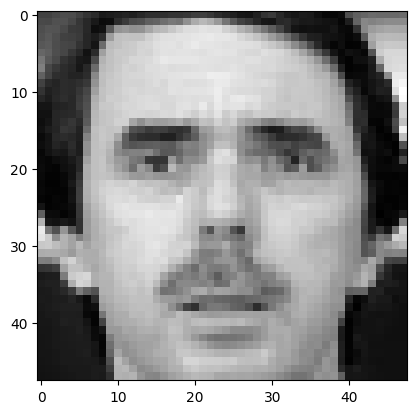

In [11]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happiness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted Output: neutral


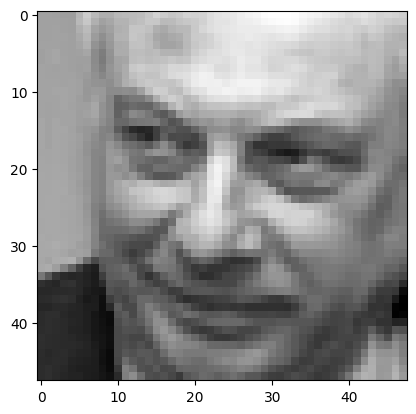

In [12]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Output: neutral


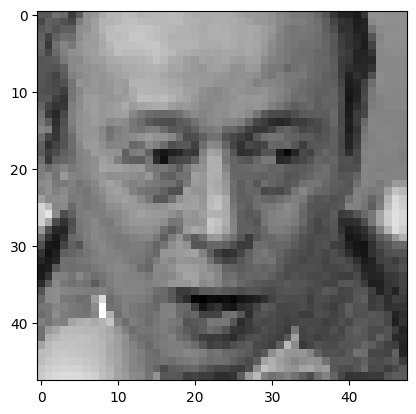

In [10]:
import random
import matplotlib.pyplot as plt
image_index = random.randint(0, len(test))
print("Original Output:", test['emotion'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [9]:
# VGG16 Model (with frozen layers)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(48, 48, 3))  # Use (48, 48, 3) as input size

# Freeze the layers of VGG16 so they are not trained
for layer in base_model.layers:
    layer.trainable = False

# Create the model with the VGG16 base
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer for emotion labels (dynamic number of classes)
])
# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Show model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 1, 1, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,849,871 (56.65 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation, only rescale the images
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(X_val) // 32
)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(X_val) // 32)
print(f"Validation loss: {val_loss}")
print(f"Validation accuracy: {val_accuracy}")


In [ ]:
# Save the trained model
model.save('vgg16_emotion_recognition_model.h5')